In [2]:
#!nvidia-smi

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [4]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 5,
    "validation_file" : 2,
    "test_file" : 2,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 3e-4,
    "scheduler_factor": 0.8,
    "scheduler_patience": 3,
    "scheduler_min_lr": 2e-5,
    "epoch" : 30,
    "model_name" : "LSTM4",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26654 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9378 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15806 [00:00<?, ?it/s]

In [5]:
torch.set_default_dtype(torch.float32)
class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = nn.LSTM(1,self.hidden_size,2,batch_first=True,bias=False)
        self.layer2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.LayerNorm(self.hidden_size),
            nn.Linear(self.hidden_size,1,bias=False),
        )
        self.layer3 = nn.Linear(1,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1,(hn,cn) = self.layer1(input)
        print("--",h1[0][0][0].item())
        output = self.layer2(h1[:,-1,:])
        output = torch.multiply(output,0.04)
        print("++",output[0][0].item())
        # output = self.layer3(h2)
        return output


In [36]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              3,147,776
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─LayerNorm: 2-2                    1,024
|    └─Linear: 2-3                       512
├─Linear: 1-3                            1
Total params: 3,149,313
Trainable params: 3,149,313
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              3,147,776
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─LayerNorm: 2-2                    1,024
|    └─Linear: 2-3                       512
├─Linear: 1-3                            1
Total params: 3,149,313
Trainable params: 3,149,313
Non-trainable params: 0

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)
loss_fn = torch.nn.MSELoss()

In [38]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

-- -7.344266487052664e-05
++ 5.548770786845125e-06
-- 6.358729297062382e-05
++ -0.004015755839645863
-- -0.0004656218516174704
++ 0.007376252673566341
-- -0.00010755291441455483
++ 0.004061204846948385
-- -5.4067742894403636e-05
++ -0.0011306452797725797
-- -2.7598685846896842e-05
++ -0.0003036178241018206
-- 0.0002723602228797972
++ -0.01055202353745699
-- -0.00011583044397411868
++ 0.0028039251919835806
-- 0.00011240242747589946
++ 0.001102498616091907
-- 5.794247772428207e-05
++ -8.700119360582903e-05
-- -0.00012361019616946578
++ 0.0008254335843957961
-- 0.0
++ 0.002511190716177225
-- -0.00010896877938648686
++ 0.007619414012879133
-- 0.00043861192534677684
++ 0.001150738913565874
-- -0.00017760256014298648
++ -0.0061962115578353405
-- 0.0
++ 0.0008498596725985408
-- 0.00017967497115023434
++ -0.0038211080245673656
-- -0.00045519295963458717
++ 0.010848534293472767
-- 0.0007706615724600852
++ 0.004166176076978445
-- 5.432568286778405e-05
++ 0.0002355367032578215
-- 1.01439854915952

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.0004419750184752047
++ 9.490639058640227e-05
-- 0.0
++ -0.0012109982781112194
-- -0.003511653281748295
++ -0.004431921523064375
-- -0.00011749719851650298
++ -4.5221597247291356e-05
-- -0.010547438636422157
++ 0.007327991537749767
-- 0.0
++ -0.00031582711380906403
-- 0.00039201873005367815
++ 0.0005411843303591013
-- 0.0
++ 0.008607217110693455
-- -0.003511789022013545
++ 8.068367606028914e-05
-- 8.390291623072699e-05
++ 0.0005759514751844108
-- -0.0036020756233483553
++ 0.020275834947824478
-- 0.00021935834956821054
++ -0.0009719878435134888
-- -4.8464298743056133e-05
++ -0.001350971288047731
-- 0.0
++ 0.0002926538872998208
-- 0.0
++ 0.0010906277457252145
-- -0.0002677063748706132
++ -0.0030070932116359472
-- -0.00017497323278803378
++ 0.0021199670154601336
-- 0.0010565328411757946
++ -0.00023036643688101321
-- -0.0005406326381489635
++ -0.0017652374226599932
-- 0.0
++ -0.0056753759272396564
-- 0.0017972382484003901
++ -0.0022709788754582405
-- -0.005809050519019365
++ -0.0038984

  0%|          | 0/209 [00:00<?, ?it/s]

-- 2.0599614799721166e-05
++ -0.0009191047283820808
-- 0.00020914655760861933
++ 0.0005137163680046797
-- -0.0020751908887177706
++ -0.0017275519203394651
-- 0.00010258746624458581
++ -0.00026482788962312043
-- 0.001013712608255446
++ -0.0013952034059911966
-- -0.0015811063349246979
++ 0.002947435947135091
-- -0.0001581472170073539
++ 0.0036664502695202827
-- -0.00017174967797473073
++ 0.0011693196138367057
-- 0.0
++ 0.008335377089679241
-- -3.3896169043146074e-05
++ 0.0016283978475257754
-- -0.00016160539234988391
++ -0.001088360557332635
-- 7.329729851335287e-05
++ 6.206234684213996e-05
-- 9.181674249703065e-05
++ 0.003256642259657383
-- 0.00037894712295383215
++ 0.010518397204577923
-- -0.00019253988284617662
++ 0.0027181387413293123
-- -4.247840843163431e-05
++ 0.0019446692895144224
-- -0.0003864733735099435
++ 0.0009653195738792419
-- -0.00016951121506281197
++ -0.011004392057657242
-- -3.657777051557787e-05
++ -0.001084065530449152
-- 0.00019762670854106545
++ 0.00318146124482154

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.0009624737431295216
++ -0.0019512873841449618
-- -0.0021665343083441257
++ -0.008711869828402996
-- 0.00017451682651881129
++ -0.004165387246757746
-- -0.0006373993819579482
++ 0.004492819309234619
-- -0.00029704204644076526
++ -0.0006463195313699543
-- -0.0006688367575407028
++ -0.008187013678252697
-- -0.0010610634926706553
++ 3.3819374948507175e-05
-- 0.0001561033568577841
++ -0.003407589392736554
-- 2.5033405108843e-05
++ 0.00055406877072528
-- -0.0007387456716969609
++ 0.0007480112835764885
-- 5.254643110674806e-05
++ -0.0004446276871021837
-- 0.0
++ -0.0018724604742601514
-- 1.602840166015085e-05
++ -0.0007845759391784668
-- -0.004456428810954094
++ -0.0016651537735015154
-- -7.594399357913062e-05
++ -0.001423998735845089
-- 5.462982880999334e-05
++ 0.0013324649771675467
-- 0.00034080067416653037
++ -0.00014971880591474473
-- -0.00020940722606610507
++ -0.0004713260568678379
-- 0.0
++ 0.019193638116121292
-- 0.00012295626220293343
++ -0.0005790340946987271
-- 0.0012127496302

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.0001851009437814355
++ -0.008073434233665466
-- -9.09873197088018e-05
++ -0.00040826169424690306
-- 0.00015871267532929778
++ -0.001654306659474969
-- 0.00037556514143943787
++ 0.0012605104129761457
-- 0.0010503418743610382
++ -0.0011118665570393205
-- -0.000726547441445291
++ -0.004810813814401627
-- 0.0006823542644269764
++ 0.0023508379235863686
-- -0.0003121451009064913
++ -0.00119549292139709
-- 0.00012378762767184526
++ 0.006394876632839441
-- 0.0
++ 0.00011547307803994045
-- -0.0015716846100986004
++ -0.005017900373786688
-- -0.00037058512680232525
++ -0.000946050335187465
-- 3.5343859053682536e-05
++ -0.009930968284606934
-- 2.0147135728620924e-05
++ -2.6929210434900597e-05
-- 0.0002630394883453846
++ 0.0019470807164907455
-- 0.00022138780332170427
++ 0.002218616893514991
-- -0.000375249917851761
++ -0.0058497837744653225
-- 5.495041477843188e-05
++ 0.0024516216944903135
-- 0.0004854804137721658
++ 0.00203380617313087
-- -0.00042963423766195774
++ 0.005305358208715916
-- 0.

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.0005300272023305297
++ 0.0010658148676156998
-- -0.00011872551840497181
++ -4.448957770364359e-05
-- -0.00036786365672014654
++ -0.001105185248889029
-- -0.0005910184700042009
++ 0.002492608968168497
-- -0.0005449139280244708
++ -0.00011354632442817092
-- -8.236555004259571e-05
++ -0.0016439533792436123
-- 0.0007345722988247871
++ -0.0024139615707099438
-- -2.2159551008371636e-05
++ -0.0015506187919527292
-- 0.005649054888635874
++ -0.010722147300839424
-- 0.0
++ -6.8479566834867e-06
-- -6.693686736980453e-05
++ -0.0003549052053131163
-- -0.0002515931846573949
++ 0.00031104582012631
-- 0.0004139048687648028
++ 0.0037130056880414486
-- 0.0
++ 1.3666227459907532e-05
-- 0.0022361567243933678
++ -0.003227980574592948
-- 0.0
++ -6.8479566834867e-06
-- 0.00017270764510612935
++ 0.0009667458361946046
-- -3.906867641489953e-05
++ -0.0005852712783962488
-- -9.623799269320443e-05
++ -0.0018780259415507317
-- -0.0006200557108968496
++ 0.0009640537900850177
-- -4.52654276159592e-05
++ 0.00080

  0%|          | 0/209 [00:00<?, ?it/s]

-- -0.00011714852007571608
++ -0.0008405040134675801
-- -4.6843841118970886e-05
++ 0.0006587880779989064
-- -8.994481322588399e-05
++ -0.0007016710587777197
-- 9.192821744363755e-05
++ -5.057962334831245e-05
-- 0.0
++ -0.0007465759408660233
-- 0.00010815680434461683
++ -0.0026505792047828436
-- 0.0001776519202394411
++ 0.00092278141528368
-- 0.0
++ 0.0009482541354373097
-- -0.00022351692314259708
++ 0.0016208287561312318
-- 8.58080165926367e-05
++ -0.0010230112820863724
-- 0.0
++ 0.005397569388151169
-- -0.00020727686933241785
++ 0.00029100076062604785
-- -0.0003747443261090666
++ 0.010175943374633789
-- -0.00048522267024964094
++ 0.0018114628037437797
-- -0.0007325134938582778
++ 0.0006792803760617971
-- -9.976415458368137e-05
++ -0.004662595689296722
-- -8.596253610448912e-05
++ 0.00018805984291248024
-- -0.0006524980999529362
++ -0.0006641307263635099
-- 0.0006618801271542907
++ 0.013340466655790806
-- 0.0
++ 0.00025527577963657677
-- 0.00017774294246919453
++ 0.001432639081031084
-

  0%|          | 0/74 [00:00<?, ?it/s]

-- -6.576704618055373e-05
++ -0.0003173886798322201
-- -2.1532927348744124e-05
++ 5.45479360880563e-06
-- 0.0
++ -0.002004764275625348
-- 0.00021993184054736048
++ 0.005088614299893379
-- -0.00040573373553343117
++ 0.0062658279202878475
-- 8.77097190823406e-05
++ 5.5259297369048e-05
-- 0.00013095424219500273
++ -0.00025518328766338527
-- 0.0
++ 0.023527182638645172
-- 1.2839890587201808e-05
++ 0.0006752070039510727
-- 0.001261474215425551
++ -0.027522012591362
-- -6.0991769714746624e-05
++ -0.00017943356942851096
-- 0.000244826078414917
++ 0.0018728518625721335
-- 7.956980698509142e-05
++ 0.0004679687262978405
-- -0.0002958536788355559
++ 0.00010425906657474115
-- 0.0008653642144054174
++ 0.0029239964205771685
-- -0.0001787038636393845
++ 0.00566105218604207
-- 0.00010560253576841205
++ -0.0004661455750465393
-- 9.265791595680639e-05
++ 0.0012912581441923976
-- 0.0
++ -8.50698706926778e-05
-- -0.0005180292064324021
++ -0.0004110380250494927
-- 0.0
++ -0.02682880498468876
-- -2.22766211

  0%|          | 0/209 [00:00<?, ?it/s]

-- 2.5941693820641376e-05
++ 0.00015847146278247237
-- -1.0704923624871299e-05
++ -0.0013217632658779621
-- 0.0
++ -0.0007123535615392029
-- 0.00016562154632993042
++ -0.00041696938569657505
-- -0.00016401821631006896
++ 0.0016030293190851808
-- -0.00012016105029033497
++ -0.00488715386018157
-- -8.450041787000373e-05
++ 0.001165608991868794
-- 0.00029523519333451986
++ 0.006012052297592163
-- 8.978000550996512e-05
++ -0.0003415904357098043
-- -0.0002117159019690007
++ -0.00017099983233492821
-- 0.00014286101213656366
++ 0.0011726146331056952
-- -5.707464515580796e-05
++ -0.000744047574698925
-- -0.00012919309665448964
++ -0.0020307651720941067
-- -0.00015180268383119255
++ -0.0007831595721654594
-- 6.920515443198383e-05
++ 0.0003383419243618846
-- 0.0
++ -5.174768011784181e-05
-- 0.0
++ 0.001275056740269065
-- -0.00010467174433870241
++ -0.0018427351024001837
-- -0.00034360415884293616
++ -0.00015757768414914608
-- 8.368676208192483e-05
++ 0.00032524197013117373
-- -0.0002358537749387

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.00017697059956844896
++ 0.004388732369989157
-- 2.1944275431451388e-05
++ -0.004372457042336464
-- 0.00024014024529606104
++ -0.009573426097631454
-- 1.64514403877547e-05
++ -6.262986426008865e-05
-- 8.386556874029338e-05
++ 0.003081218572333455
-- -0.00026599879493005574
++ -0.00043103296775370836
-- 0.0
++ 0.01631225273013115
-- 0.00020564037549775094
++ -0.0020272263791412115
-- -0.003007412888109684
++ -0.009180610999464989
-- 1.3924986888014246e-05
++ 0.0010104955872520804
-- 0.0
++ -0.014639673754572868
-- 0.0
++ 0.008960804902017117
-- 0.00015972272376529872
++ 0.0062483553774654865
-- -0.002741315634921193
++ -0.01310583483427763
-- 0.006153571419417858
++ -0.018491549417376518
-- 6.138656317489222e-05
++ 0.008182603865861893
-- 4.102363527636044e-05
++ 0.0006410524365492165
-- -0.00023066152061801404
++ -0.0032255544792860746
-- -5.550728747039102e-05
++ 0.002817481756210327
-- -0.0003018885909114033
++ 0.002618157770484686
-- -0.0012973089469596744
++ 0.00867688003927469

  0%|          | 0/209 [00:00<?, ?it/s]

-- -0.00013938179472461343
++ -0.001482024323195219
-- -1.3239239706308581e-05
++ 0.0012189771514385939
-- -0.00024761661188676953
++ -0.010133692994713783
-- 0.0003801376442424953
++ 0.007071491330862045
-- 0.0002346093242522329
++ 0.0008519625407643616
-- 9.846772627497558e-06
++ 0.0009510426898486912
-- -0.001556058181449771
++ 0.004308624658733606
-- 0.0
++ 0.001055245054885745
-- 0.00015211434219963849
++ -0.0015356013318523765
-- 0.00014448958972934633
++ -0.0029066281858831644
-- 0.00017383124213665724
++ 0.007879977114498615
-- -4.441754936124198e-05
++ -0.000368652050383389
-- -0.0005147172487340868
++ -0.0019411386456340551
-- -0.00011892664042534307
++ 0.00016146557754836977
-- -7.469714182661846e-05
++ -0.0025821852032095194
-- -0.00020951098122168332
++ 0.003142318921163678
-- -5.4103245929582044e-05
++ -0.0004714634269475937
-- -0.00020309770479798317
++ 0.0016278460389003158
-- -5.525022424990311e-05
++ -9.3752947577741e-05
-- -2.517237044230569e-05
++ 4.08048754252377e-

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.004039774648845196
++ -0.02228551357984543
-- 0.00014849712897557765
++ -0.014179633930325508
-- 0.00015002567670308053
++ 0.0004352164105512202
-- -0.0002484736032783985
++ -0.000314652977976948
-- 0.00021319770894479007
++ 0.0010194294154644012
-- 0.0023571583442389965
++ -0.0013091331347823143
-- -5.986427640891634e-05
++ -0.0023551464546471834
-- 0.01178552582859993
++ -0.015113551169633865
-- 0.0001933610183186829
++ -0.004498351830989122
-- -9.462828165851533e-05
++ -0.0028925479855388403
-- -6.634541205130517e-05
++ -0.0023849622812122107
-- -5.724285074393265e-05
++ 0.00010012699203798547
-- 0.0
++ -2.021797808993142e-05
-- -0.00010248377657262608
++ -0.00012824221630580723
-- 0.0
++ 0.0009965680073946714
-- 0.0
++ 0.0011319001205265522
-- -0.000359915109584108
++ 0.03561326116323471
-- 0.0
++ 0.004064225126057863
-- -0.0003149291733279824
++ 0.0008723179344087839
-- -0.00018332889885641634
++ -0.00926573108881712
-- -0.0005341104697436094
++ 0.005186015274375677
-- 0.0004

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.00031036330619826913
++ -0.002865345450118184
-- 0.0019181793322786689
++ -0.010229879058897495
-- -0.000342437851941213
++ -0.004048080183565617
-- -0.0002619637525640428
++ 0.0032250331714749336
-- -0.0006249122088775039
++ -0.00270584924146533
-- 0.0
++ -0.00023089535534381866
-- 9.157542808679864e-05
++ 0.0008549004560336471
-- 0.0
++ -0.0003152647113893181
-- 0.00012534427514765412
++ -0.00027794609195552766
-- -1.9481820345390588e-05
++ -0.000856562633998692
-- 4.081404404132627e-05
++ -0.0002583956520538777
-- 0.0
++ 0.0017074280185624957
-- -1.099629207601538e-05
++ -0.00139880389906466
-- 0.0006862073787488043
++ -0.0016412677941843867
-- 0.0001343788899248466
++ -0.0015967885265126824
-- -5.9494741435628384e-05
++ 0.00035524810664355755
-- -8.557276305509731e-05
++ 0.00017452552856411785
-- 0.0
++ 0.0026936663780361414
-- 7.78290705056861e-05
++ -0.0006183436489664018
-- -0.00011479660315671936
++ -0.0020375207532197237
-- 3.09295610350091e-05
++ -0.0005092578358016908
-

  0%|          | 0/74 [00:00<?, ?it/s]

-- -0.0020350287668406963
++ -0.0032582490239292383
-- -8.191420783987269e-05
++ -0.0018769885646179318
-- 0.0003013626846950501
++ 0.004310919903218746
-- 0.0006857869448140264
++ -0.0003618189657572657
-- 0.0004002395726274699
++ -0.0036341222003102303
-- 0.0012006768956780434
++ 0.00202049408107996
-- 0.00022584978432860225
++ -0.00036686580278910697
-- 0.0
++ -0.0002583859604783356
-- -0.000602796848397702
++ -0.0009472334641031921
-- 0.0
++ -0.0007112916209734976
-- 0.0003915499255526811
++ -0.0006374857621267438
-- -0.0007612693589180708
++ 0.0006439460557885468
-- 0.000411333458032459
++ 0.0033203347120434046
-- -0.0008546506869606674
++ 0.0077520874328911304
-- 0.00018496584380045533
++ 0.012411782518029213
-- 0.0
++ 0.008874156512320042
-- 8.959943806985393e-05
++ -0.00014487162115983665
-- 5.995902756694704e-05
++ -0.00039679871406406164
-- 0.0
++ -0.005098589695990086
-- 0.000937298871576786
++ -0.001592269167304039
-- -0.0002995292597915977
++ -0.0055228243581950665
-- -0.0

  0%|          | 0/209 [00:00<?, ?it/s]

-- -0.00011556893878150731
++ -0.0007957408670336008
-- 0.0
++ -0.020677799358963966
-- -4.855997394770384e-05
++ -0.0012661077780649066
-- 0.0012161966878920794
++ -0.0033004595898091793
-- 0.0
++ -0.002380391350015998
-- -7.74673098931089e-05
++ -0.0004999343655072153
-- -0.000332563096890226
++ 0.0020799078047275543
-- 0.0004210007027722895
++ -0.0026415649335831404
-- -0.005713889840990305
++ -0.009149051271378994
-- -0.00019120675278827548
++ -0.0001923948439070955
-- -0.000470049271825701
++ 0.0002021806431002915
-- -0.0006941106985323131
++ -0.0010914768790826201
-- 0.0
++ 9.952965774573386e-05
-- 0.00032786367228254676
++ -8.717726450413465e-05
-- -0.00027887910255230963
++ -0.0006557360175065696
-- -0.0004341167223174125
++ -0.0008167556370608509
-- -0.00015386813902296126
++ -6.620777276111767e-05
-- 0.0001499002828495577
++ 0.001773487194441259
-- 0.0
++ 0.00016571134619880468
-- 4.617985541699454e-05
++ 0.00010234834189759567
-- -4.0025544876698405e-05
++ 0.0002097475808113

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.00025531105347909033
++ 0.0007488916744478047
-- 0.0007738125859759748
++ 0.0010613814229145646
-- 0.00037146618706174195
++ -0.0003796301316469908
-- -0.0004938611527904868
++ 0.0017706211656332016
-- 0.0
++ 0.007004281040281057
-- 0.000777938577812165
++ -0.002106910804286599
-- -0.00011187458585482091
++ -0.001417479943484068
-- 0.0
++ 0.0007529477588832378
-- 0.0017171510262414813
++ -0.001470537157729268
-- 0.0002303405781276524
++ -0.0013353618560358882
-- -0.00020829953427892178
++ 0.0016875748988240957
-- 0.00011125603487016633
++ -0.0009628363768570125
-- 0.0
++ 0.00714593892917037
-- 0.0006000357097946107
++ -0.0026218779385089874
-- -0.00021647411631420255
++ 0.004550438839942217
-- -0.0029492799658328295
++ 0.0019821934401988983
-- 0.00020297059381846339
++ 0.003394894301891327
-- 0.00020916858920827508
++ 0.000175460270838812
-- 9.152296115644276e-05
++ 7.199698302429169e-06
-- -0.0022732303477823734
++ -0.028667114675045013
-- -0.0015427586622536182
++ 0.022520253434

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.00015577211161144078
++ 0.0005960550042800605
-- -6.307765579549596e-05
++ -0.0009352859924547374
-- -4.826804797630757e-05
++ 0.0008668783702887595
-- 0.0
++ -0.01437126100063324
-- 0.0
++ -0.002397136064246297
-- -0.00011533805081853643
++ 0.0006574240978807211
-- 4.622199048753828e-05
++ 0.0014507462037727237
-- -0.00021980394376441836
++ 3.448267307248898e-05
-- -0.00012376306403893977
++ -0.0006427570478990674
-- -0.00044239661656320095
++ 0.0035038914065808058
-- 3.3702952350722626e-05
++ -0.0006649359129369259
-- 0.00021118111908435822
++ -0.0008376451442018151
-- 0.0008212546817958355
++ 0.0005681999609805644
-- 7.026319508440793e-05
++ 0.0008207457140088081
-- 0.0012024273164570332
++ 0.00018425578309688717
-- -6.262748502194881e-05
++ 0.0005038942908868194
-- -0.0003540748730301857
++ 6.548587407451123e-05
-- 0.0
++ -0.0011380678042769432
-- -0.00012377186794765294
++ -0.0006542039336636662
-- 0.0
++ 0.003279749071225524
-- -4.194162102066912e-05
++ -0.000202596158487722

  0%|          | 0/74 [00:00<?, ?it/s]

-- 6.270149606280029e-05
++ -0.0005548267508856952
-- 0.00013717090769205242
++ -0.00023342783970292658
-- 0.0
++ -0.0016332062659785151
-- -0.0003244620456825942
++ -0.0018458075355738401
-- 0.00015421629359479994
++ -8.610050281276926e-05
-- 0.00013775612751487643
++ -0.0002292955614393577
-- -0.0007777716382406652
++ 0.0007818078738637269
-- 6.0121528804302216e-05
++ -0.0002744165249168873
-- 0.0022579533979296684
++ -0.003654977073892951
-- -0.0008379675564356148
++ -0.002773385029286146
-- -0.007469210308045149
++ -0.00788198783993721
-- 0.00034184972173534334
++ 0.002392211463302374
-- -0.0002057501405943185
++ 0.0056018834002316
-- -0.0002784217067528516
++ 0.0011001884704455733
-- 0.0004390432150103152
++ -0.0019802080933004618
-- -0.0002371590817347169
++ 0.0007884457008913159
-- -0.002493105595931411
++ 0.002943967003375292
-- 6.688854045933113e-05
++ 1.8403743524686433e-05
-- 0.0002864193811547011
++ 0.0036071129143238068
-- 0.0005089851329103112
++ 0.0013488820986822248
-- 

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.0002526765747461468
++ -0.0008395377080887556
-- -7.549225847469643e-05
++ 4.331289528636262e-05
-- -0.00022150932636577636
++ -0.0012166353408247232
-- 0.0001113946782425046
++ -0.0007640757248736918
-- 0.0001575583009980619
++ -0.0018910096259787679
-- -0.00013707367179449648
++ -0.0016044900985434651
-- 7.490465213777497e-05
++ -0.0001998463849304244
-- 1.3082010809739586e-05
++ 0.00035204418236389756
-- 1.587989208928775e-05
++ 0.002081221668049693
-- -4.032101423945278e-05
++ -7.489277777494863e-05
-- 9.15973141673021e-05
++ 0.0006269719451665878
-- -0.00017867425049189478
++ -0.0008246931247413158
-- 0.0
++ -0.0006809431943111122
-- 7.462736539309844e-05
++ -0.002261773217469454
-- 0.0003707554133143276
++ -0.00023834001331124455
-- -0.00011720442125806585
++ -0.0005540690617635846
-- 0.00016466084343846887
++ -0.00053520651999861
-- 0.0
++ 0.0002771101426333189
-- 0.0006908167852088809
++ 0.00605081906542182
-- 0.00042563845636323094
++ -0.0006524797645397484
-- -0.00042307

  0%|          | 0/74 [00:00<?, ?it/s]

-- -0.0010280630085617304
++ -0.0008457787334918976
-- -0.0008199569419957697
++ 0.0018906526966020465
-- -0.0019128876738250256
++ -0.001683066482655704
-- 0.0006509940722025931
++ -0.0004890773561783135
-- 0.015386831946671009
++ -0.015966035425662994
-- 0.0
++ 0.0037325499579310417
-- 0.0
++ 0.00038048229180276394
-- 0.0006298151565715671
++ -0.003449366893619299
-- -0.0004762728058267385
++ -0.0015039584832265973
-- -0.0002678241580724716
++ 0.003664172487333417
-- 0.0002034929784713313
++ -0.0020488996524363756
-- -4.1919571231119335e-05
++ 0.006189099512994289
-- -0.0003097968001384288
++ 0.00413472531363368
-- 0.00041479789069853723
++ 0.0003694151237141341
-- -0.00012413845979608595
++ 0.001171948155388236
-- 0.0
++ -0.009001102298498154
-- 0.0
++ -0.008828174322843552
-- 0.007560129277408123
++ 0.0030514842364937067
-- 0.00017652208043728024
++ 0.000808996323030442
-- 0.0
++ 0.004225258249789476
-- 0.0001776007266016677
++ 0.001376794883981347
-- 0.0
++ 0.0026365122757852077
-

  0%|          | 0/209 [00:00<?, ?it/s]

-- -0.00039529832429252565
++ -0.0013784148031845689
-- -7.86317978054285e-05
++ 0.0012920069275423884
-- -0.00038324532215483487
++ 0.0010339728323742747
-- 0.0
++ 0.0008203665493056178
-- -0.00010334604303352535
++ 0.001598775153979659
-- 0.0006117216544225812
++ -0.004880254622548819
-- 0.0
++ 0.00029052409809082747
-- 0.0
++ 0.0030583899933844805
-- 0.00043951673433184624
++ 0.00827328022569418
-- -0.00015870689821895212
++ 0.0005344075034372509
-- 0.0
++ 0.00021824074792675674
-- -0.00016562151722609997
++ -0.0002298236358910799
-- -0.00037621299270540476
++ 0.00046837664558552206
-- -0.00036034578806720674
++ 0.007269277237355709
-- -0.0006372532807290554
++ -0.0009594624862074852
-- 7.158899097703397e-05
++ -0.00017128764011431485
-- -0.00020779338956344873
++ 0.0008909115567803383
-- 0.0002890208561439067
++ -3.463323082542047e-05
-- 5.991696161800064e-05
++ 0.0005956043023616076
-- 0.0003626690013334155
++ -0.0009166338131763041
-- -0.00018392280617263168
++ 0.0006901907618157

  0%|          | 0/74 [00:00<?, ?it/s]

-- 1.7014750483212993e-05
++ -0.0003673644387163222
-- 0.00027049038908444345
++ 0.0022697332315146923
-- 0.0
++ -0.011725337244570255
-- 0.0
++ -0.018720583990216255
-- -0.0005355703178793192
++ 0.003922183532267809
-- 0.004550375044345856
++ -0.0017943682614713907
-- 0.00012664345558732748
++ 0.00016420539759565145
-- -0.0003503872430883348
++ 0.003169562201946974
-- 0.0
++ 0.00024029034830164164
-- -0.00329007999971509
++ -0.012589417397975922
-- -1.6487158063682728e-05
++ -0.00010455332812853158
-- -0.003370210062712431
++ -0.017420891672372818
-- -0.00030895229429006577
++ -0.0009057235438376665
-- 0.00025602823006920516
++ 0.0045722005888819695
-- -0.0001296170084970072
++ 0.00020585092715919018
-- 0.0019615567289292812
++ -0.0009075903799384832
-- 0.00727629940956831
++ 0.03949945420026779
-- 0.0010266955941915512
++ 0.0032559451647102833
-- 0.00014144828310236335
++ 0.0008618744323030114
-- 0.0
++ 3.4869317460106686e-05
-- -0.0005116935353726149
++ -0.0009924913756549358
-- -0.

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.0
++ 0.0009257530327886343
-- 0.000296471465844661
++ -0.001320920535363257
-- 0.0006058738799765706
++ 0.0017394605092704296
-- -0.00037220778176561
++ -0.0005907980375923216
-- 0.0
++ 0.004044900648295879
-- -0.0012348538730293512
++ 0.0036848317831754684
-- -0.0005770704010501504
++ -0.012011231854557991
-- 0.0012635630555450916
++ -0.016072630882263184
-- 0.0006307325675152242
++ 0.00012042062735417858
-- 2.8244650820852257e-05
++ 0.00012217789480928332
-- -0.0015499144792556763
++ -0.0008617373532615602
-- 0.00034360933932475746
++ -3.0439699912676588e-05
-- -0.00048006721772253513
++ -0.0008073514327406883
-- 0.0
++ 0.0003978282038588077
-- 2.599303661554586e-05
++ 4.013810757896863e-05
-- -0.0002530180208850652
++ 0.00012314182822592556
-- 4.575891944114119e-05
++ -3.923690383089706e-05
-- 3.621797077357769e-05
++ -0.0002310520358150825
-- 0.0
++ 0.00017114804359152913
-- 0.0005103903240524232
++ -0.0007246019667945802
-- 0.00025507123791612685
++ -0.0011300635524094105
-- 

  0%|          | 0/74 [00:00<?, ?it/s]

-- -0.00010997812205459923
++ 0.0027559467125684023
-- 0.0
++ 0.000945062143728137
-- 0.0004753769317176193
++ -0.0005626139463856816
-- 0.0
++ 0.031028155237436295
-- -0.0009587880922481418
++ -0.006014603655785322
-- 0.0001285852340515703
++ 0.0005985616589896381
-- -0.0006806209567002952
++ -0.00043810185161419213
-- 0.0
++ 4.984408587915823e-05
-- 0.0
++ 9.586250962456688e-05
-- 0.00010552615276537836
++ 0.0014889021404087543
-- 0.0002685463987290859
++ -0.004309840966016054
-- 0.00031782774021849036
++ 0.00034612082527019083
-- 2.4136168576660566e-05
++ 0.0011381498770788312
-- 0.0007003088830970228
++ 0.0015038555720821023
-- 4.0719543903833255e-05
++ 0.0021614914294332266
-- -0.0001126576607930474
++ -0.006432702299207449
-- -0.001108514959923923
++ 0.014797735959291458
-- 0.0
++ 9.586250962456688e-05
-- -0.0002263926580781117
++ 0.0008503536810167134
-- 0.0028964283410459757
++ -0.010864820331335068
-- 0.0
++ -0.00043617270421236753
-- 0.00030243428773246706
++ 0.00089278368977

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.0003151187556795776
++ 3.175752135575749e-05
-- -0.00012151093687862158
++ 0.00048527162289246917
-- -7.762990571791306e-05
++ 0.00020783017680514604
-- -0.00039658701280131936
++ 0.0066718184389173985
-- 0.0
++ -8.198220166377723e-05
-- 0.0
++ 0.001632530940696597
-- -0.00018241768702864647
++ 0.0019334054086357355
-- 0.0
++ 0.0001113477410399355
-- 0.0
++ 0.000467372708953917
-- -0.00023985642474144697
++ 0.0011123928707093
-- -0.00012210599379613996
++ 0.0035421797074377537
-- -1.627637175261043e-05
++ -0.0005602146266028285
-- -0.00015219082706607878
++ -0.000527906056959182
-- 0.00010098630446009338
++ -1.2304790288908407e-06
-- -8.078711834968999e-05
++ -2.3815873646526597e-05
-- -2.7526730264071375e-05
++ 9.912805398926139e-05
-- 0.00010721918079070747
++ 0.00018653068400453776
-- -5.900375981582329e-05
++ 0.0003495325508993119
-- -0.0006437029805965722
++ 0.0012158615281805396
-- -2.2553538656211458e-05
++ -0.0005308394320309162
-- 0.0
++ 0.0004982067621313035
-- -7.173888

  0%|          | 0/74 [00:00<?, ?it/s]

-- -0.00010091835429193452
++ 0.00037655196501873434
-- 0.0
++ -0.012712165713310242
-- 1.2469782632251736e-05
++ 0.0012704308610409498
-- -1.8789216483128257e-05
++ -0.0007955125765874982
-- -0.0001066486511263065
++ 0.00018771439499687403
-- 0.0001323562319157645
++ -0.0009490467491559684
-- -0.0002892470802180469
++ -0.000581009837333113
-- 0.00013658545503858477
++ -0.0002958924451377243
-- 0.00014762271894142032
++ 0.00046715751523151994
-- 9.679012873675674e-05
++ -0.0008745138184167445
-- 0.00026064153644256294
++ -0.0003032651438843459
-- 1.3985756595502608e-05
++ 0.00047877265023998916
-- 0.0
++ -0.0006938689621165395
-- -0.0001430320699000731
++ 7.841437764000148e-05
-- 0.0001343260082649067
++ -0.0005638126167468727
-- 0.00224497402086854
++ -0.007222241722047329
-- 0.0
++ -0.015240117907524109
-- -3.421803921810351e-05
++ -0.00020099288667552173
-- -5.627142309094779e-05
++ 0.0004289747739676386
-- 0.0009991191327571869
++ 0.0012979885796085
-- 0.0
++ 0.00029304344207048416

  0%|          | 0/209 [00:00<?, ?it/s]

-- 2.1143563571968116e-05
++ 0.0002835864434018731
-- 0.0
++ -0.0005627171485684812
-- -1.3060761375527363e-05
++ 0.00030755254556424916
-- 3.928394289687276e-05
++ 0.00014387744886334985
-- 9.075552952708676e-05
++ 0.0008403535466641188
-- 0.00043189534335397184
++ 0.0024263481609523296
-- -0.0002632503747008741
++ -4.646000434149755e-06
-- -0.0002592791570350528
++ 0.004092148970812559
-- -0.00033636714215390384
++ 0.0005610973457805812
-- -9.346869774162769e-05
++ 0.0013237058883532882
-- 9.9530654551927e-05
++ 0.00038923174724914134
-- 0.0
++ 0.0006778112147003412
-- 0.0
++ 0.0011863572290167212
-- -9.740614768816158e-05
++ 0.0005625270423479378
-- -0.00017650860536377877
++ -0.00029000500217080116
-- -5.3790527090313844e-06
++ -0.0002846205607056618
-- 0.0001324984768871218
++ -0.0031120488420128822
-- -7.772228855174035e-05
++ -0.0005384079995565116
-- 2.1945234038867056e-05
++ -0.00021615359582938254
-- 4.9898793804459274e-05
++ 6.757334631402045e-05
-- 0.0
++ 0.0002378222125116

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.00021043852029833943
++ 0.003440030850470066
-- 0.00021751134772785008
++ -2.2602594071940985e-06
-- 6.610384298255667e-05
++ 0.003321992699056864
-- 0.0
++ 0.00017015516641549766
-- 0.0
++ -0.0010824899654835463
-- 0.0
++ 0.027904225513339043
-- 3.859033313347027e-05
++ 0.0019060785416513681
-- 0.0
++ -0.0010496571194380522
-- 0.000995542504824698
++ -0.0027174153365194798
-- 0.00015941867604851723
++ -0.00052832585060969
-- 0.00026759476168081164
++ 0.002770261373370886
-- 0.00017850853328127414
++ 0.0017107385210692883
-- -6.659318751189858e-05
++ -0.00018872581131290644
-- 0.0002955211966764182
++ 0.0007838691817596555
-- 0.00017079079407267272
++ 0.000148482431541197
-- 7.736579573247582e-05
++ -0.0012450171634554863
-- 0.00010334968101233244
++ 0.002222673036158085
-- -0.00020735873840749264
++ 0.0002569202915765345
-- 0.0009376354282721877
++ -0.0007007115636952221
-- -0.00046138843754306436
++ 0.002232029801234603
-- 0.00046922476030886173
++ 0.01828913204371929
-- -0.0001

  0%|          | 0/209 [00:00<?, ?it/s]

-- -8.084898581728339e-05
++ -0.0008241100586019456
-- 7.191748591139913e-05
++ 0.004349678289145231
-- 0.0
++ 0.0012913079699501395
-- 0.000613292446359992
++ 0.004344141110777855
-- -0.00025385996559634805
++ -0.00637418357655406
-- 2.2939042537473142e-05
++ 0.0014412185410037637
-- 0.0002507200406398624
++ 0.003399728098884225
-- -0.0001121427194448188
++ -0.0017295487923547626
-- 0.0
++ 0.001399874803610146
-- 1.375900592393009e-05
++ -0.00032949401065707207
-- 3.6239103792468086e-05
++ -0.00016622428665868938
-- 2.079283876810223e-05
++ -0.004480763338506222
-- -0.00018351415928918868
++ 0.0012318931985646486
-- -9.324472193839028e-05
++ 0.00037547535612247884
-- 0.0
++ -0.07883661240339279
-- 7.72465136833489e-06
++ -0.0014153922675177455
-- 0.0
++ -0.003061040071770549
-- 4.226915189065039e-05
++ 0.0005593124660663307
-- -6.619910709559917e-05
++ 0.0034007802605628967
-- 0.00014976914098951966
++ 0.001454209559597075
-- -2.9178389013395645e-05
++ 0.0003364491858519614
-- -0.0003

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.00010754117829492316
++ -0.001216893084347248
-- -3.1612911698175594e-05
++ 0.0021090928930789232
-- 1.011284166452242e-05
++ -0.0007634225185029209
-- 6.904726615175605e-05
++ 0.0018941687885671854
-- -0.00048240783507935703
++ 0.005499848164618015
-- 1.6857360606081784e-05
++ 0.0017913986230269074
-- 0.00011809773423010483
++ -0.0032798978500068188
-- 3.900457522831857e-05
++ 0.001608769060112536
-- -3.186712638125755e-05
++ 0.0010640493128448725
-- -3.4344189771218225e-05
++ -0.002337933285161853
-- 0.0
++ 0.0024608245585113764
-- 0.0
++ -0.00013342588499654084
-- 1.0898220352828503e-05
++ 0.00025046017253771424
-- -1.733915451040957e-05
++ -0.0018738126382231712
-- -4.6973509597592056e-05
++ 0.0004976222990080714
-- 7.561971870018169e-05
++ 0.006364031229168177
-- 0.00011550180352060124
++ 0.0056188167072832584
-- -0.00026946316938847303
++ -0.0012107293587177992
-- 0.0004079525824636221
++ 0.0015102067263796926
-- 0.0004789186641573906
++ -0.001791277900338173
-- 0.0001632183

  0%|          | 0/209 [00:00<?, ?it/s]

-- 2.7696749384631403e-05
++ -0.00039775631739757955
-- 0.000264849019004032
++ 0.00039060719427652657
-- -0.00017580037820152938
++ -0.0006177382310852408
-- 0.0
++ 0.0011281004408374429
-- 7.909740816103294e-05
++ -0.00022636174981016666
-- 0.0
++ 0.0010167668806388974
-- 0.0007291543297469616
++ 0.008223730139434338
-- 2.787259654724039e-05
++ -0.0006578347529284656
-- 4.999875818612054e-05
++ 0.0008404607651755214
-- 0.00026057253126055
++ -0.004063939675688744
-- 9.270179725717753e-05
++ 0.0003147632523905486
-- 1.0669190487533342e-05
++ 6.9867915044596884e-06
-- 0.0004225224256515503
++ 0.0010699948761612177
-- -7.701127287873533e-06
++ -0.0033661434426903725
-- 0.00019403902115300298
++ 0.010532972402870655
-- 0.0002935487136710435
++ 0.0047519756481051445
-- 0.0
++ -0.0008497147355228662
-- -0.00031540938653051853
++ 0.0022327180486172438
-- 0.00011676258873194456
++ -0.00015599734615534544
-- -0.0003667692362796515
++ 0.0036153870169073343
-- 0.0001377250300720334
++ -0.000570

  0%|          | 0/74 [00:00<?, ?it/s]

-- 6.221695366548374e-05
++ 0.00014262893819250166
-- -1.4701479813084006e-05
++ -0.0006025356706231833
-- -0.00042751291766762733
++ -0.0038077463395893574
-- 0.0
++ 0.001995170721784234
-- 0.003359462833032012
++ 0.0016946353716775775
-- 0.0
++ -0.005519322119653225
-- 0.00011983291915385053
++ -0.0023484346456825733
-- 0.0004160162643529475
++ -0.0009371630731038749
-- 0.0005472971824929118
++ -0.0006797619280405343
-- -0.0003242462989874184
++ -0.0013401012402027845
-- 0.00028536422178149223
++ 0.003544609062373638
-- -0.00014301568444352597
++ 0.000572819379158318
-- -0.0011911436449736357
++ 0.04561759531497955
-- -0.0005073701031506062
++ 0.0008846024284139276
-- 0.0007566229323856533
++ -0.0009987789671868086
-- 0.0
++ 0.004213225562125444
-- -0.0007871814887039363
++ -0.00215686927549541
-- 0.00029816123424097896
++ -0.004033553414046764
-- -1.0617378393362742e-05
++ -0.0011450599413365126
-- 0.0
++ 0.0228344164788723
-- 0.0005929435137659311
++ 0.0019245618022978306
-- 0.0
++

  0%|          | 0/209 [00:00<?, ?it/s]

-- -4.0254439227283e-05
++ 0.00032818649196997285
-- 0.0
++ 8.463194535579532e-05
-- -0.0002847652940545231
++ -0.0006894495454616845
-- 0.0
++ 0.0015652271686121821
-- 0.0
++ 0.00010005413059843704
-- 0.00011831902520498261
++ -0.00032664136961102486
-- 0.0
++ -0.00019782470189966261
-- 0.0
++ 0.00014201867452356964
-- -0.00011345324310241267
++ 0.0005357297486625612
-- 2.6544174033915624e-05
++ 7.310120417969301e-05
-- -0.00029372735298238695
++ -0.0007456623716279864
-- 3.943425326724537e-05
++ 0.0005976739339530468
-- -0.00016770388174336404
++ -4.772274041897617e-05
-- -4.6676257625222206e-05
++ -0.0002402444079052657
-- 0.00012305437121540308
++ 0.0004224399453960359
-- 0.0
++ 0.002561173401772976
-- -0.00021513507817871869
++ 0.00019955000607296824
-- 0.0
++ 0.0013690409250557423
-- 0.0001286916813114658
++ 0.00015450152568519115
-- -0.00010259370174026117
++ 0.002363001462072134
-- -0.00011923437705263495
++ 0.0003346200683154166
-- -8.672767580719665e-05
++ 0.00078065507113933

  0%|          | 0/74 [00:00<?, ?it/s]

-- -0.00077871885150671
++ 0.0027508113998919725
-- 0.00021482491865754128
++ 3.8258047425188124e-05
-- 0.0
++ -0.021738437935709953
-- -0.00014757875760551542
++ -0.0038150805048644543
-- 0.00028824922628700733
++ -0.002329552313312888
-- 0.00027663042419590056
++ -0.0021251763682812452
-- 9.205841342918575e-05
++ -0.00041788723319768906
-- 6.157239840831608e-05
++ -0.0011851147282868624
-- 0.0030882926657795906
++ 0.031073642894625664
-- 0.0
++ -0.000447987113147974
-- -0.0008426732383668423
++ 0.0006528063677251339
-- 1.5113773770281114e-05
++ -0.00034119721385650337
-- 0.00012636565952561796
++ -0.0007134547922760248
-- -7.936734618851915e-06
++ -0.00035361858317628503
-- -0.0005277126329019666
++ -0.007994920015335083
-- -0.0008161054574884474
++ -0.011913692578673363
-- 0.0
++ -0.010856302455067635
-- 0.00014924927381798625
++ -0.00072482816176489
-- -0.0004187883751001209
++ 0.0017838163767009974
-- 4.954533505951986e-05
++ 0.0014347058022394776
-- 0.0
++ 0.006338363513350487
--

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.00042082593427039683
++ -0.0003900574811268598
-- -0.0002672573318704963
++ 0.012393531389534473
-- 4.5910233893664554e-05
++ 0.0003333132772240788
-- 9.115821012528613e-05
++ -0.0008878661319613457
-- 0.00010515987378312275
++ -0.0006675979821011424
-- 7.75370717747137e-05
++ 3.296083741588518e-05
-- -5.8775247453013435e-05
++ -0.0011943966383114457
-- 9.416360990144312e-05
++ -0.0015747379511594772
-- 8.819214417599142e-05
++ 0.00025840289890766144
-- -0.00016001782205421478
++ 0.002100305864587426
-- 0.0
++ 0.0002984419115819037
-- 0.00018103439651895314
++ -0.0020863786339759827
-- -1.469380731577985e-05
++ -0.00034956238232553005
-- -0.00013292967923916876
++ 0.0018295120680704713
-- 7.919259223854169e-05
++ 0.00020420014334376901
-- 0.0
++ -0.00015145589713938534
-- 0.0003181874635629356
++ -0.0008655075798742473
-- 0.0002174425171688199
++ -0.0003725105489138514
-- -0.00016922781651373953
++ 0.0005885877762921154
-- -0.0002639847807586193
++ -0.0006093939882703125
-- 3.8887

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.0
++ 0.0003418349660933018
-- 2.2474045181297697e-05
++ -0.00019666941079776734
-- -7.759584150335286e-06
++ 0.0003434121608734131
-- -4.836955122300424e-05
++ 0.000680685683619231
-- 0.0
++ 0.0003418349660933018
-- 0.0020728770177811384
++ -0.0005232780240476131
-- 0.000148980034282431
++ 0.00033865502336993814
-- 0.0
++ 0.006826511584222317
-- 0.0003965224605053663
++ -0.005079257767647505
-- -2.336659235879779e-05
++ -0.0006593529833480716
-- 4.2799954826477915e-05
++ 0.0006224529352039099
-- -0.00020076487271580845
++ -0.006643599830567837
-- -5.30885299667716e-05
++ 0.000727845705114305
-- 2.0176319594611414e-05
++ 0.00015605459338985384
-- 0.0028937426395714283
++ -0.0010761775774881244
-- -0.00020272060646675527
++ -0.00010728722554631531
-- 0.0
++ -3.9419381209881976e-05
-- 9.459813736611977e-05
++ 4.948175046592951e-05
-- 0.009992259554564953
++ 0.010599029250442982
-- -7.916088179626968e-06
++ 0.0003767946327570826
-- -6.691543967463076e-05
++ -0.0006168161053210497
-- 7

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.0
++ 0.0002800525981001556
-- 0.00011712146078934893
++ 0.0006251599988900125
-- 3.8060377846704796e-05
++ 0.0001400792971253395
-- 0.0
++ 0.00032118469243869185
-- -0.00015643442748114467
++ 0.0010754544055089355
-- 9.418406989425421e-05
++ 0.0006419271812774241
-- 0.0002848517324309796
++ 3.713263140525669e-05
-- 0.00014623228344134986
++ 0.0001330039231106639
-- -7.513069431297481e-05
++ 0.0002701797347981483
-- -1.1769596312660724e-05
++ 0.000273930374532938
-- 1.5702349628554657e-05
++ 0.00012173267168691382
-- 8.770803106017411e-05
++ 0.00041406761738471687
-- -6.793477950850502e-05
++ -0.0010259904665872455
-- 0.0
++ 0.000327717891195789
-- 5.966667686152505e-06
++ 0.002188460435718298
-- -0.00012672465527430177
++ 0.004597185645252466
-- 7.531946175731719e-05
++ 0.001759501756168902
-- 0.00012492825044319034
++ -0.0016627752920612693
-- 2.1076057237223722e-05
++ 0.0006218040362000465
-- -6.997523450991139e-05
++ -0.0005531532224267721
-- 0.0
++ 0.00025942313368432224
-- 2.

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.0
++ -0.0008360522915609181
-- 5.7985555031336844e-05
++ -0.00039884677971713245
-- -6.455351467593573e-06
++ -8.406260167248547e-05
-- -4.300203363527544e-05
++ -0.0016457620076835155
-- -2.4479219064232893e-05
++ -0.00034495576983317733
-- 2.8860254133178387e-06
++ 2.261633017042186e-05
-- -4.7186276788124815e-05
++ -0.00047008998808450997
-- -2.3469352527172305e-05
++ -0.00015693609020672739
-- -1.6339768990292214e-05
++ 0.0004784042539540678
-- 1.4950034710636828e-05
++ 0.00017933490744326264
-- 8.680672908667475e-05
++ 0.0003089090168941766
-- -2.633550320751965e-05
++ 0.0005659774760715663
-- 3.9613737499166746e-06
++ 0.00046695556375198066
-- 2.0324327124399133e-05
++ -5.980689820717089e-05
-- 6.711461901431903e-05
++ -0.00015979040472302586
-- -4.914772216579877e-05
++ 0.0018136592116206884
-- 0.0
++ -0.002922358689829707
-- 0.0025203765835613012
++ -7.605520659126341e-05
-- -4.2745705286506563e-05
++ -0.00018563597404863685
-- 5.046928708907217e-05
++ 0.000177650901605375

  0%|          | 0/209 [00:00<?, ?it/s]

-- 1.1263443411735352e-05
++ 0.00023798507754690945
-- 0.0
++ -2.394840066699544e-06
-- 9.627926374378148e-06
++ -0.00020625273464247584
-- 0.0
++ 0.010193034075200558
-- 9.475934348301962e-06
++ 0.00013360024604480714
-- 3.286462015239522e-05
++ -9.337428491562605e-05
-- 3.1777817639522254e-05
++ -0.00012996411533094943
-- 7.998103683348745e-06
++ 0.0001549167645862326
-- -3.60083176929038e-05
++ -0.0003883576428052038
-- -0.00012089932715753093
++ 0.0004926472902297974
-- -1.4950512195355259e-05
++ -0.00021571370598394424
-- 3.3617452572798356e-06
++ 0.00022470041585620493
-- -3.474301774986088e-05
++ 8.90473966137506e-05
-- 5.818455065309536e-06
++ 0.00015408682520501316
-- 4.11705377700855e-06
++ -3.668861972982995e-05
-- -6.301818757492583e-06
++ -4.897827602690086e-05
-- -0.00011388518032617867
++ 0.0017948667518794537
-- 9.845350723480806e-05
++ -0.001081945956684649
-- -1.819433964556083e-05
++ -0.00016710165073163807
-- 0.00010483288497198373
++ 0.00017776608001440763
-- 2.503

  0%|          | 0/74 [00:00<?, ?it/s]

-- -5.872145629837178e-05
++ 0.0002658625890035182
-- 0.0001650323683861643
++ 0.0006151250563561916
-- -0.00018151337280869484
++ 0.0016570062143728137
-- 0.0012469807406887412
++ -0.010626065544784069
-- 0.0
++ -0.0008965060114860535
-- 3.4615848562680185e-05
++ -0.01770268753170967
-- -0.0001902490039356053
++ 0.006394499447196722
-- 0.0
++ 0.06868278980255127
-- -0.00012506364146247506
++ -0.00026948779122903943
-- 0.0
++ 0.036366239190101624
-- -0.00013492350990418345
++ -0.0006056420970708132
-- 9.800210682442412e-05
++ 0.001900339499115944
-- -1.2996534678677563e-05
++ -0.0007544190157204866
-- 0.0
++ 0.05271510034799576
-- 0.0
++ 0.00022664332936983556
-- 0.0
++ -0.0007853233837522566
-- 0.00015937858552206308
++ 0.0017973132198676467
-- -8.00498019088991e-05
++ -0.0011884277919307351
-- 0.0004810084355995059
++ -0.0036622988991439342
-- 4.956185875926167e-05
++ -7.238522084662691e-05
-- 0.00010140031372429803
++ -0.000121076445793733
-- 4.998270742362365e-05
++ 0.0007331020897

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.00010646250302670524
++ 0.0015938071301206946
-- 1.2768790838890709e-05
++ 0.0002461468684487045
-- -7.199178799055517e-05
++ 0.0005770330899395049
-- -0.0004269626224413514
++ 0.004465771373361349
-- 4.006541712442413e-05
++ 0.0007066373946145177
-- -0.00019534661259967834
++ 0.0006485980120487511
-- 2.676762960618362e-05
++ 0.0007417768356390297
-- -5.093168147141114e-05
++ 0.00026405544485896826
-- -0.00046960858162492514
++ 0.0030228160321712494
-- -0.0002146071201423183
++ 0.0037175267934799194
-- 0.00012896886619273573
++ 0.0008568097255192697
-- -2.4396365915890783e-05
++ 0.0002334399032406509
-- -2.6865003746934235e-05
++ -0.002022312255576253
-- -7.005835504969582e-05
++ 0.0007612316985614598
-- 7.508504495490342e-05
++ 0.0001726714544929564
-- -4.4941360101802275e-05
++ 0.0011683296179398894
-- -2.8272592317080125e-05
++ -0.0007536555640399456
-- 8.439343946520239e-05
++ 0.0008652626420371234
-- -9.605491504771635e-05
++ 0.0014151576906442642
-- 0.0005123026203364134
++ 

  0%|          | 0/74 [00:00<?, ?it/s]

-- 3.170601303281728e-06
++ 0.00041438231710344553
-- 0.0
++ -0.030969442799687386
-- 9.808464710658882e-06
++ -0.0003806641325354576
-- 3.3940825233003125e-05
++ 0.0005984439630992711
-- 7.109657872206299e-06
++ 0.0001277974370168522
-- -4.0083475028040993e-07
++ 5.370957660488784e-05
-- 0.0
++ -0.008543374016880989
-- 3.910854047717294e-06
++ -0.0014670118689537048
-- 0.006217895075678825
++ -0.024564094841480255
-- 0.0001696592225925997
++ 0.0010085293324664235
-- 0.0
++ -0.0017599784769117832
-- 6.184632752592734e-07
++ -5.709822289645672e-06
-- 1.3190977369959e-05
++ 0.007572319358587265
-- 1.1972524589509703e-05
++ -0.0015046303160488605
-- 0.00043092729174531996
++ 0.019933704286813736
-- 7.161350481510453e-07
++ 0.0009252167074009776
-- 1.7850734366220422e-06
++ -0.0005679562455043197
-- 0.0
++ -0.0036055834498256445
-- 1.513393726781942e-05
++ -0.0002316044847248122
-- -6.754199262104521e-07
++ 0.0011794210877269506
-- 1.2199072443763725e-05
++ 0.0003125667863059789
-- 6.62213

  0%|          | 0/209 [00:00<?, ?it/s]

-- 1.2133682503190357e-06
++ -0.00011018569057341665
-- 4.769103156831989e-07
++ 0.0003313897759653628
-- 1.5888095958871418e-06
++ -0.0008446205174550414
-- 2.5380743409186834e-06
++ 0.00038860211498104036
-- 4.626788722816855e-05
++ -0.0009238063939847052
-- 4.621672360372031e-07
++ 0.00032779615139588714
-- 1.428273748160791e-07
++ 8.754645386943594e-05
-- -1.700115035419003e-07
++ 0.0002866902214009315
-- -4.2837260139094724e-07
++ 0.0011900347890332341
-- 5.081240487925243e-06
++ 7.58841706556268e-05
-- 2.110987679770915e-06
++ 0.00010317897977074608
-- 8.380600775126368e-06
++ 0.0002702095662243664
-- 5.756560494774021e-05
++ 0.0016137458151206374
-- -8.237304427893832e-06
++ -0.00019664663705043495
-- -3.7441207041410962e-06
++ 0.0002802891540341079
-- -4.168632131040795e-06
++ 0.0002441836695652455
-- 8.321391942445189e-05
++ -7.579805969726294e-05
-- 2.2775820980314165e-06
++ -0.0001509046123828739
-- 4.691698450187687e-06
++ 0.0020270333625376225
-- 0.0001054794411174953
++ 0

  0%|          | 0/74 [00:00<?, ?it/s]

-- -7.609010481246514e-06
++ 5.048776074545458e-05
-- 6.537594890687615e-05
++ 0.00431638490408659
-- 0.0
++ -0.0005352307925932109
-- -7.361758889601333e-06
++ -0.00045644291094504297
-- 1.8650986021384597e-05
++ 0.0003927500220015645
-- -3.744459718291182e-06
++ 1.7225256669917144e-05
-- 0.0
++ -0.00023421255173161626
-- -3.980465407948941e-06
++ 0.0003006988554261625
-- 0.0024919563438743353
++ -0.013817251659929752
-- 4.946245098835789e-06
++ 0.0002066368906525895
-- 0.0
++ -0.03189822658896446
-- -3.37540063810593e-06
++ -4.548952711047605e-05
-- 0.0003495151177048683
++ -0.0014912732876837254
-- 8.04206956672715e-06
++ -9.781948756426573e-05
-- 9.692783351056278e-06
++ -1.7378395568812266e-05
-- 7.389587608486181e-06
++ 6.516947905765846e-05
-- 1.8105803974322043e-05
++ -6.757544724678155e-06
-- 0.0022918598260730505
++ -0.007595348171889782
-- 0.0
++ -0.00884724035859108
-- 0.0
++ 0.024586021900177002
-- 4.9514841521158814e-05
++ -9.649412822909653e-05
-- 6.04615297561395e-06
++

  0%|          | 0/209 [00:00<?, ?it/s]

-- -5.010855147702387e-06
++ -0.0008963076397776604
-- 0.000319393613608554
++ 0.006698405370116234
-- -7.0802193476993125e-06
++ -0.00028424846823327243
-- 6.914013965797494e-07
++ -0.00014643844042439014
-- 0.0
++ -0.00012972750118933618
-- 1.495250103289436e-06
++ 8.348767732968554e-05
-- 9.47228108998388e-05
++ -9.776632214197889e-05
-- 1.658143628446851e-05
++ -0.0003512897528707981
-- 0.0
++ -0.00016181988758035004
-- -8.723211976757739e-06
++ 0.0011338848853483796
-- -2.4019964257604443e-06
++ 7.248362180689583e-06
-- 1.6803543985588476e-05
++ 0.0007369992672465742
-- 9.918028808897361e-06
++ -0.0002685652580112219
-- 4.939564405503916e-06
++ -6.639950879616663e-05
-- -1.1074143003497738e-05
++ 0.0006092370022088289
-- 0.0
++ -0.0005869007436558604
-- 3.982158432336291e-06
++ 5.424315168056637e-05
-- 1.169076313090045e-05
++ -0.00018612090207170695
-- 0.0
++ -0.00637695100158453
-- -6.06535422775778e-06
++ 0.001890211016871035
-- 3.0562437132175546e-06
++ 4.892327979177935e-06
-

  0%|          | 0/74 [00:00<?, ?it/s]

-- 5.174576290301047e-05
++ 0.0012506390921771526
-- 9.852629773376975e-06
++ 0.0003539905301295221
-- -1.2693762073467951e-05
++ 0.0004120130615774542
-- 1.1495681064843666e-05
++ 0.0004404370265547186
-- 0.0
++ 0.00010447610111441463
-- 1.267722041120578e-06
++ -8.377568883588538e-05
-- 0.0
++ -0.002364865969866514
-- 0.0
++ -0.0028913659043610096
-- 3.515596836223267e-05
++ 0.004907574038952589
-- 0.00040781183633953333
++ -0.0033061716239899397
-- -9.950897037924733e-06
++ 2.5309858756372705e-05
-- 6.631672476942185e-06
++ -2.7095275072497316e-05
-- 0.00030706124380230904
++ 0.0014410690637305379
-- 0.00011714141146512702
++ -0.00033951157820411026
-- 0.0
++ -0.003191799856722355
-- 0.0
++ 0.0004571055178530514
-- -2.0738382318086224e-06
++ 0.0005548537592403591
-- -1.4111565178609453e-05
++ 0.00014207935601007193
-- -1.3936942195869051e-05
++ 0.0011716665467247367
-- 2.0621155272237957e-05
++ -1.9533558770490345e-06
-- 2.9570950573543087e-05
++ 0.0038932072930037975
-- 2.395167211

  0%|          | 0/209 [00:00<?, ?it/s]

-- 1.5452238585567102e-05
++ -0.0002101252175634727
-- -3.3825613172666635e-06
++ 6.120566831668839e-05
-- -7.52473795273545e-07
++ -0.00015530179371125996
-- 1.943657025549328e-06
++ 0.00027689189300872386
-- 1.809291097742971e-05
++ 0.00030396823422051966
-- -3.197258820364368e-06
++ 0.00393889332190156
-- -1.5455650554940803e-06
++ -0.00017977073730435222
-- 5.732053978135809e-06
++ 0.0004890971467830241
-- 0.0006243298994377255
++ -0.004467816557735205
-- 2.8353972538752714e-06
++ 0.00010494023445062339
-- -8.585645900893724e-07
++ 0.0013398333685472608
-- 7.3053461164818145e-06
++ -0.0003875663678627461
-- 7.236928354359407e-07
++ 0.0001915761095006019
-- 7.259512130985968e-06
++ 0.001187919988296926
-- 1.1114252629340626e-06
++ 0.0006009390926919878
-- 4.7606414455003687e-07
++ 0.00039381562964990735
-- 8.114026286420994e-07
++ -0.00026847238768823445
-- -5.77130720103014e-07
++ -0.0005061421543359756
-- 1.6963233520073118e-06
++ 0.0012574733700603247
-- -7.773754191475746e-07
++

  0%|          | 0/74 [00:00<?, ?it/s]

-- -1.9815235646092333e-05
++ 9.870690701063722e-05
-- -1.5525942217209376e-05
++ 0.0004925582907162607
-- 0.0
++ -0.017939193174242973
-- -7.146940333768725e-05
++ 0.0051894113421440125
-- 3.167622708133422e-06
++ -9.200163185596466e-05
-- -5.098758265376091e-05
++ -0.0015222871443256736
-- 0.0004080240905750543
++ -0.0014611802762374282
-- -6.0925358411623165e-05
++ -0.00025058042956516147
-- 3.5393244615988806e-05
++ 0.00021006609313189983
-- 3.436714905546978e-05
++ 8.484694262733683e-05
-- -3.313874185550958e-05
++ -4.0328948671231046e-05
-- -2.912881609518081e-05
++ 0.0006352179334498942
-- 0.0
++ -0.00929347239434719
-- 4.127387364860624e-05
++ 0.0022927983663976192
-- -7.1300397394225e-05
++ -0.00992364902049303
-- 1.54152003233321e-05
++ -0.00026016845367848873
-- 0.00013221903645899147
++ 0.0021780994720757008
-- 0.00018791286856867373
++ 0.0005812788149341941
-- -7.309154898393899e-05
++ 0.00389054324477911
-- 0.0
++ -0.002246598480269313
-- -5.466134098242037e-05
++ 0.00080

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.0
++ -0.000377726333681494
-- 3.734022811840987e-06
++ -3.766671579796821e-05
-- 9.926250641001388e-06
++ 1.2472527487261686e-05
-- -3.941770410165191e-05
++ -0.000277436978649348
-- -5.5766231525922194e-05
++ -0.0027999114245176315
-- 5.6502162806282286e-06
++ 0.0005280712503008544
-- 0.0006463283207267523
++ 0.003150136675685644
-- -2.7424328436609358e-05
++ 0.0020284196361899376
-- 3.854382612189511e-06
++ 0.0005278587341308594
-- 0.000480734946904704
++ -0.00030007577151991427
-- 2.6316154617234133e-05
++ -0.00033563925535418093
-- 3.373661820660345e-05
++ 0.0011728988029062748
-- -6.84273436490912e-06
++ 0.0002990489883814007
-- -7.3176065598090645e-06
++ 5.2270748710725456e-05
-- -3.4780287023750134e-06
++ 0.00022165819245856255
-- -1.4452611139859073e-05
++ 0.00016063328075688332
-- 8.100362720142584e-06
++ -1.1473207450762857e-05
-- -1.9545215764082968e-05
++ 0.00015968497609719634
-- -1.1387075574020855e-05
++ 0.00025249875034205616
-- 0.0
++ 0.00027738831704482436
-- -1.

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.00016269029583781958
++ 0.00014299197937361896
-- 0.0
++ 0.009782077744603157
-- 0.0
++ -0.002085071988403797
-- -2.985752416861942e-06
++ 0.004348623566329479
-- 7.710824866080657e-05
++ -0.0023352745920419693
-- 0.00015260098734870553
++ 0.001392151229083538
-- 0.0
++ 0.0002987602783832699
-- 0.0
++ -4.241766146151349e-05
-- 3.0383860121219186e-06
++ 0.0003264699480496347
-- 2.470775507390499e-05
++ -0.001130449352785945
-- 6.16147826804081e-06
++ 0.0004456300230231136
-- 4.1339939343743026e-05
++ 0.0003854991518892348
-- -4.45427804152132e-06
++ 0.001952307648025453
-- 1.4199209545040503e-05
++ 8.768139377934858e-05
-- 4.398104010761017e-06
++ 0.0003075211134273559
-- 1.4999753148003947e-05
++ -0.0004108957073185593
-- -4.503869604377542e-06
++ -0.0005883036064915359
-- 1.614183565834537e-05
++ 6.901269807713106e-05
-- -9.044287594406342e-07
++ 0.0029912670142948627
-- 0.0
++ -0.0011981994612142444
-- 4.0100359910866246e-05
++ 0.00030522028100676835
-- -3.5669754652190022e-06
+

  0%|          | 0/209 [00:00<?, ?it/s]

-- 1.0651689990481827e-05
++ 0.00031929175020195544
-- -4.219189577270299e-06
++ 0.0002507207391317934
-- 0.0006870613433420658
++ -2.457102709740866e-05
-- -1.8296243524673628e-06
++ 0.0003132910351268947
-- 1.2753351256833412e-05
++ 3.187426409567706e-05
-- 5.21707397638238e-06
++ 0.00027952634263783693
-- 0.0
++ 0.0006268874276429415
-- 4.851839548791759e-05
++ 0.0005106042372062802
-- -9.500777764515078e-07
++ 4.62678617623169e-05
-- 0.0
++ -4.598228770191781e-05
-- 9.310277846452664e-07
++ 0.00030593713745474815
-- 5.4633037507301196e-05
++ 0.0030718089547008276
-- 2.2443136913352646e-06
++ 0.0002134416572516784
-- 1.8436046957504004e-05
++ 0.00036728917621076107
-- 2.6666157282306813e-06
++ 0.0009148876997642219
-- -1.274190822186938e-06
++ 0.0003919641312677413
-- -1.3369126463658176e-06
++ 0.0006007527699694037
-- 2.164021282169415e-07
++ -0.000154314300743863
-- 2.4478179057041416e-06
++ 0.0002203781477874145
-- -5.917751764172863e-07
++ 0.0005019200616516173
-- -1.35571247028

  0%|          | 0/74 [00:00<?, ?it/s]

-- 6.075812962080818e-06
++ 1.494775278843008e-05
-- 2.0549701730487868e-05
++ 0.0002789663849398494
-- 1.889929990284145e-05
++ 0.0031044636853039265
-- 1.4801959196120151e-06
++ 0.0022222117986530066
-- 0.0
++ 0.0002965252206195146
-- 3.027877028216608e-05
++ -0.00021451229986269027
-- -5.232776629782165e-07
++ 0.0008198162540793419
-- 0.0
++ -0.0044792406260967255
-- 1.4894564628775697e-05
++ 0.0005069458275102079
-- 0.0
++ 0.00022190087474882603
-- -2.2575993341433787e-07
++ 0.0002697447198443115
-- 0.0
++ -0.06963436305522919
-- 2.7966625566477887e-05
++ 0.0047439634799957275
-- 1.1837277043014183e-06
++ -0.0008625849732197821
-- 4.60923183709383e-06
++ 0.00045395269989967346
-- -6.128002496552654e-07
++ 0.004153341054916382
-- 8.028877346077934e-06
++ 0.001216044882312417
-- 1.2980359315406531e-05
++ 0.005137620959430933
-- 1.5189247051239363e-06
++ -0.0005356898182071745
-- 7.815023855073377e-05
++ 0.004051057621836662
-- 5.907254490011837e-06
++ 0.0002504426520317793
-- -6.0824

  0%|          | 0/209 [00:00<?, ?it/s]

-- 4.157127023063367e-06
++ 0.00043647646089084446
-- 2.58849894407831e-07
++ 0.00035119327367283404
-- -9.844583814810903e-08
++ 0.00015507638454437256
-- 1.6440350009361282e-05
++ 0.0004871507699135691
-- 0.0
++ 0.000359679339453578
-- 3.542650688359572e-07
++ 0.00011778237239923328
-- 0.0
++ -5.622581738862209e-05
-- 0.0
++ 0.00018400834233034402
-- 5.6493395277357195e-06
++ 0.00015689052816014737
-- 7.740155751889688e-07
++ 0.0003202980733476579
-- 4.003599087809562e-07
++ 0.00017108138126786798
-- 5.5653735842042806e-08
++ 7.369484228547662e-05
-- 5.6376075008301996e-06
++ 0.00016563535609748214
-- 4.1335849232382316e-07
++ -6.213551387190819e-05
-- 4.330522642703727e-07
++ 0.0010168765438720584
-- 1.5634308283551945e-06
++ 0.00039545472827740014
-- 1.7741949704941362e-05
++ -0.00032202492002397776
-- -1.9318697752623848e-07
++ 5.504709861270385e-07
-- 3.64502056982019e-06
++ 0.0002875719510484487
-- 4.401523767683102e-07
++ 0.0008499167743138969
-- -9.959439921658486e-07
++ -0.00

  0%|          | 0/74 [00:00<?, ?it/s]

-- -7.664687473152298e-06
++ 0.00030670984415337443
-- 0.0
++ -2.3908363800728694e-05
-- -1.2322607290116139e-05
++ 0.0038166719023138285
-- 0.00021054364333394915
++ 0.012223657220602036
-- 0.0
++ -0.000168161655892618
-- 7.091381121426821e-06
++ -0.00033481806167401373
-- -7.578802069474477e-06
++ 0.0003839183191303164
-- -9.234960089088418e-06
++ 0.0003995771985501051
-- 0.0
++ -1.202475596073782e-05
-- -1.642741153773386e-05
++ 0.0026688287034630775
-- 6.094032505643554e-05
++ 0.0006183389341458678
-- -1.9768610854953295e-06
++ 3.87061845685821e-06
-- -1.6632055121590383e-05
++ -0.0001743496541166678
-- 1.9818295186269097e-05
++ 0.0001262947916984558
-- -1.655140658840537e-05
++ 0.001654303167015314
-- 2.04851839953335e-05
++ 0.0002908002061303705
-- 6.529319944093004e-05
++ -0.0007839052705094218
-- -3.6846674902335508e-06
++ 8.896648796508089e-05
-- -1.6695777958375402e-05
++ -7.485007517971098e-05
-- 0.00020104454597458243
++ -0.0002906381560023874
-- 9.897667041514069e-05
++ 0.

  0%|          | 0/209 [00:00<?, ?it/s]

-- -4.912726581096649e-06
++ 6.070354356779717e-05
-- -8.58891144162044e-06
++ -0.00021272498997859657
-- 1.4491039337372058e-06
++ 0.00017757739988155663
-- 0.0002623611653689295
++ 0.001628985395655036
-- 1.3905099876865279e-05
++ -0.00029142978019081056
-- 0.0
++ 0.0004104619147256017
-- 2.3020127628115006e-05
++ -0.00039984117029234767
-- 3.9317823393503204e-05
++ 0.00030444024014286697
-- -1.4126433143246686e-06
++ 0.00044624588917940855
-- 1.4608580386266112e-05
++ 0.0017898742808029056
-- 2.711689921852667e-05
++ 0.00029556211666204035
-- -2.114448307111161e-06
++ 0.00032600833219476044
-- -4.574241756927222e-06
++ -7.919343624962494e-05
-- 0.0
++ -8.132239599945024e-06
-- 4.784081465913914e-05
++ -0.00030341820092871785
-- -1.8055055988952518e-05
++ -0.00016214187780860811
-- -1.9392620743019506e-05
++ -0.0005097970133647323
-- 3.486607283775811e-06
++ 0.0002871009928639978
-- 7.094903594406787e-06
++ 0.0004658379184547812
-- 4.283402631699573e-06
++ 9.650325227994472e-05
-- -9

  0%|          | 0/74 [00:00<?, ?it/s]

-- -5.634300032397732e-05
++ -0.0005799742066301405
-- 0.00022902838827576488
++ -0.006447030697017908
-- 0.0
++ -0.010097654536366463
-- -1.4649819604528602e-05
++ 0.00024578487500548363
-- 0.0
++ -0.0001396012376062572
-- 0.0
++ 0.11511789262294769
-- -8.379079190490302e-06
++ -0.0001349027152173221
-- 3.418834967305884e-05
++ 0.0004142608377151191
-- 1.3467692951962817e-05
++ -0.00024805800057947636
-- 0.0
++ -0.011609244160354137
-- -1.7074464267352596e-05
++ -0.00314981397241354
-- 0.0001408911484759301
++ -0.0023388320114463568
-- -4.322914173826575e-05
++ -0.00017503729031886905
-- -1.381312631565379e-05
++ 0.0006161199416965246
-- 0.0001282052107853815
++ 2.7897991458303295e-05
-- -2.473398853908293e-05
++ -0.00020491301256697625
-- -1.7830920114647597e-05
++ -0.0004174810601398349
-- 0.00020774452423211187
++ 0.002346375025808811
-- 1.2912108104501385e-05
++ -0.0003263868566136807
-- -2.8978611226193607e-05
++ -0.0065550850704312325
-- 2.2633577827946283e-05
++ -0.002075159456

  0%|          | 0/209 [00:00<?, ?it/s]

-- 0.00026052535395137966
++ 0.0011207328643649817
-- -2.7985532142338343e-05
++ 0.0004560217203106731
-- -8.676337529323064e-06
++ 0.0005089145852252841
-- -6.703193776047556e-06
++ 0.00012793678615707904
-- 0.00011006855493178591
++ 0.0030961954034864902
-- 3.432769517530687e-05
++ 0.0004445679660420865
-- -3.586455704862601e-06
++ 0.0002511392522137612
-- 1.8734506284090457e-06
++ -0.0002668594243004918
-- 3.7732967030024156e-05
++ 0.00013973524619359523
-- -1.6383952242904343e-05
++ 0.0002695272851269692
-- -3.780345286941156e-05
++ 0.00344946701079607
-- -1.0446098713146057e-05
++ 0.00010071898577734828
-- -2.0250892703188583e-05
++ -7.154564173106337e-06
-- 0.0001259681594092399
++ 0.0007642878335900605
-- -1.246567080670502e-06
++ 0.0003848388441838324
-- -2.0379429770400748e-05
++ -6.0561822465388104e-05
-- -2.59775642916793e-05
++ 0.0015607407549396157
-- -8.822061317914631e-06
++ -7.234171062009409e-05
-- -3.1870233215158805e-05
++ -0.0038944785483181477
-- 0.0
++ 0.000472937

  0%|          | 0/74 [00:00<?, ?it/s]

-- 0.0
++ 0.016477109864354134
-- 0.0
++ -0.004472915083169937
-- 4.9906166168511845e-06
++ -0.0017729264218360186
-- 9.75958118942799e-06
++ 0.0001829230022849515
-- 2.305283004488956e-07
++ -0.0002399963850621134
-- 2.5467770115028543e-07
++ -1.2063849680998828e-05
-- 7.397517038043588e-05
++ 0.0009500532178208232
-- 2.8925517199240858e-06
++ -0.000300667918054387
-- 1.8991913464105892e-07
++ 0.00042531226063147187
-- -2.625825459290354e-07
++ 0.0002179252333007753
-- -4.103108039998915e-07
++ -0.0001705815375316888
-- 1.3555782061303034e-06
++ 0.00021136541909072548
-- 3.6245135106582893e-06
++ -0.0006425322499126196
-- 3.0917435651645064e-05
++ -0.0017690842505544424
-- 2.2620512027060613e-05
++ -0.001008220249786973
-- 4.754941073770169e-06
++ 0.0005085369921289384
-- 3.201842218913953e-06
++ -0.0012166507076472044
-- 0.0
++ -0.0003378960827831179
-- 4.2279629269614816e-05
++ -0.0006905415211804211
-- 0.0
++ -0.0008626062190160155
-- 8.770662134338636e-06
++ 0.00011318981705699116

  0%|          | 0/209 [00:00<?, ?it/s]

-- 1.479051661590347e-06
++ 0.00010435752483317629
-- 3.0382971090148203e-06
++ -8.1002785009332e-05
-- 0.00017609789210837334
++ 0.0004297918058000505
-- -7.058125675030169e-07
++ 0.0001473752490710467
-- -1.0250049626847613e-06
++ -0.0009877149714156985
-- 4.279306813259609e-05
++ 0.0002252895646961406
-- 0.0
++ 6.902074528625235e-05
-- 2.6690513550420292e-05
++ -0.0003625304962042719
-- -1.5892895817160024e-06
++ 9.575856529409066e-05
-- -1.6465489807160338e-06
++ -1.9406985302339308e-05
-- 4.3064601413789205e-06
++ 0.0006795102963224053
-- 1.5828624100322486e-06
++ -0.0005841288366355002
-- 1.8251861320095486e-06
++ 0.0001841962366597727
-- 1.6753834643168375e-05
++ 0.0005322763463482261
-- 2.5671584808151238e-05
++ 0.0006553248385898769
-- 9.180562301480677e-06
++ 0.0001824522769311443
-- 3.6549288324749796e-06
++ 2.301980202901177e-05
-- -6.121673550296691e-07
++ 0.00014566676691174507
-- 0.0
++ -0.0006214143359102309
-- 3.5065490919805598e-06
++ 0.0005334613379091024
-- 3.632272

  0%|          | 0/74 [00:00<?, ?it/s]

-- -7.435519819409819e-06
++ 0.0002220743481302634
-- 0.0
++ 9.41272810450755e-05
-- 2.7689649868989363e-05
++ 0.00026461758534424007
-- 1.2841001080232672e-05
++ 0.00031852954998612404
-- -2.5923414796125144e-05
++ 0.003209527349099517
-- 2.6497425551497145e-06
++ -0.00029607556643895805
-- -2.6666670237318613e-05
++ -0.00078534334897995
-- -1.734008765197359e-05
++ 0.00031955158920027316
-- 1.402910584147321e-05
++ -0.0012551310937851667
-- -7.115519565559225e-06
++ 0.0017730244435369968
-- 0.0
++ 0.0015970313688740134
-- 0.0
++ -0.0004942517844028771
-- -1.2483705177146476e-05
++ 0.0007848397945053875
-- 0.0012039074208587408
++ -0.023862475529313087
-- 4.5722961658611894e-05
++ 0.00036760978400707245
-- -2.604599103506189e-05
++ -0.00027145451167598367
-- 1.875764428405091e-05
++ 0.00034408518695272505
-- 0.0
++ 0.0035296822898089886
-- 1.927211087604519e-05
++ 0.000213578314287588
-- 2.5284891307819635e-05
++ -0.00046365088201127946
-- -1.3504760318028275e-05
++ -0.000367524160537

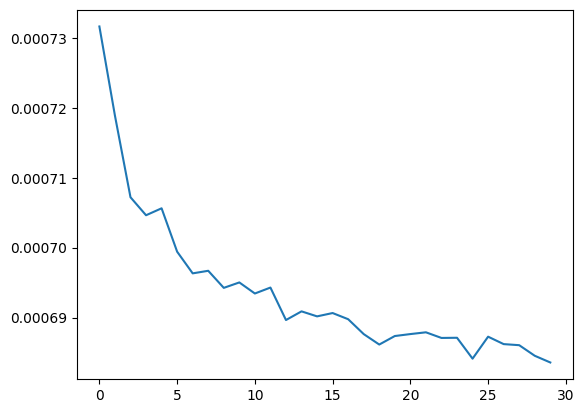

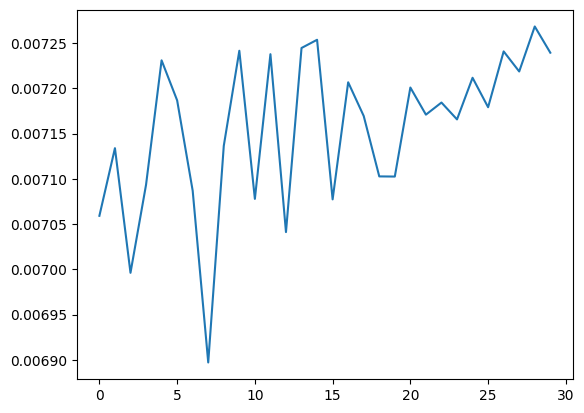

In [39]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [40]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [6]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTM(1, 512, num_layers=2, bias=False, batch_first=True)
  (layer2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=512, out_features=1, bias=False)
  )
  (layer3): Linear(in_features=1, out_features=1, bias=False)
)

In [42]:

with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/124 [00:00<?, ?it/s]

-- 2.2033140339772217e-05
++ 0.005331871565431356
-- 0.0
++ 0.0004677831311710179
-- 5.586989573203027e-05
++ 0.0007230881601572037
-- 0.002786236582323909
++ 0.00012758761295117438
-- -0.00013827696966473013
++ -0.00211929134093225
-- 0.00042272545397281647
++ 0.0030093358363956213
-- 0.0017049260204657912
++ -0.007466738577932119
-- 0.0007928326376713812
++ -0.002480071736499667
-- 0.0002204884949605912
++ -0.0007061370415613055
-- -0.00011328906111884862
++ 0.00017506422591395676
-- 0.00048285291995853186
++ 0.0013554689940065145
-- -0.000372469105059281
++ 0.005597129464149475
-- 8.731255366001278e-05
++ -0.0018146305810660124
-- 0.00040203653043136
++ 0.00036387844011187553
-- 0.00017012532043736428
++ -0.0022134280297905207
-- 0.001016609137877822
++ -0.0012254691682755947
-- 0.00029191613430157304
++ -0.00019919246551580727
-- 0.00021431704226415604
++ -0.0009872567607089877
-- 3.667840428533964e-05
++ -0.0050604213029146194
-- -0.0007143616676330566
++ -0.003702896647155285
-- 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

-- -0.0014124823501333594
++ -0.0021342081017792225
0.01762162335216999 -> -0.0021342081017792225
-- 0.00033037239336408675
++ -0.012132884003221989
-0.034217946231365204 -> -0.012132884003221989
-- 0.0012258341303095222
++ -0.002059099031612277
0.07664325088262558 -> -0.002059099031612277
-- 0.0003918157599400729
++ 0.002288159914314747
-0.036060839891433716 -> 0.002288159914314747
-- -0.00010623108391882852
++ 0.0009353911154903471
0.0027709915302693844 -> 0.0009353911154903471
-- -0.0004284691240172833
++ 0.001635667635127902
-0.0016680554253980517 -> 0.001635667635127902
-- -0.00015075734700076282
++ -0.006086369510740042
0.02955888770520687 -> -0.006086369510740042
-- 0.00031846066121943295
++ -0.0018356527434661984
0.010282871313393116 -> -0.0018356527434661984
-- 0.00045414711348712444
++ -0.0018651359714567661
0.0038400974590331316 -> -0.0018651359714567661
-- 0.0002827262505888939
++ 0.0036251216661185026
-0.030528495088219643 -> 0.0036251216661185026
-- -0.0001324341428698972

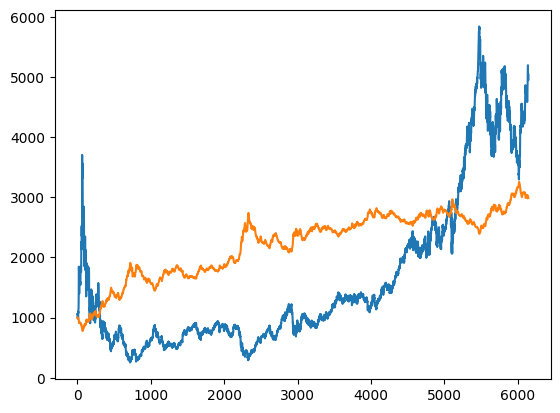

[0.9978680677010314, 0.9958211518404454, 0.9963703440641819, 0.9951645480578519, 0.9967148961326864, 0.9979878201983559, 0.9975850106445967, 1.000255438055947, 0.9992594491446457, 1.0053669868169703, 1.005586123379515, 1.0028608825404166, 0.9945757588194648, 0.9965341982572944, 0.9967983388732046, 0.9961898146520017, 0.9945602476086605, 0.9922340454796554, 0.9947143251604253, 0.9894606073632279, 0.9831460094140846, 0.9825384119811047, 0.9928567392091459, 1.0006510059995783, 1.004114871404402, 1.0057973314891258, 1.003879330255798, 0.9975078982068659, 0.9986734491196234, 1.0012410021332152, 0.9988186015074143, 0.9971764743497138, 0.995273469177498, 0.9966271953745387, 1.001154714771492, 1.000276377280018, 1.0001746451144788, 1.0012887796171825, 1.0005176152725035, 1.0002123568155716, 1.001104521200021, 1.0033703972194692, 0.9993881678008834, 0.9937603547653057, 0.9911114251872796, 0.9951206812813086, 0.9943652101025612, 0.9943280613072035, 1.000518476842741, 0.9987870037506352, 1.000966

In [8]:
plot_dataset = StockDatasetLogReturn(["./data/A.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
rd.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(input[None,4,:,None])
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        print(close_price_input[0][-1].item(),"->",output[0][0].item())
        output = output.to(torch.device("cpu")).numpy()

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real)
plt.plot(predict)
plt.show()
print(predict_output)

[]

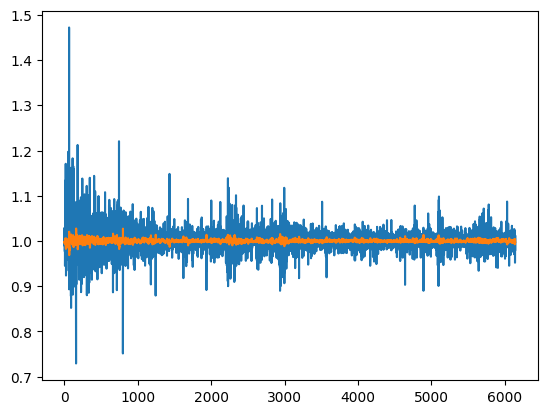

In [9]:
plt.plot(real_output)
plt.plot(predict_output)
plt.plot()

In [19]:
print(np.mean((np.log(np.array(real_output)) * np.log(np.array(predict_output))) > 0))

0.4939778645833333


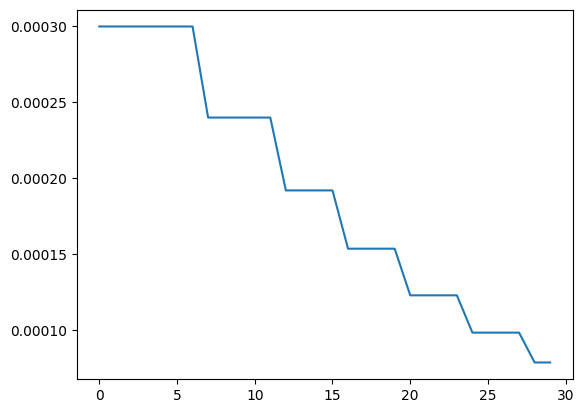

In [45]:
plt.plot(learning_rates)
plt.show()